In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and Prepare Data

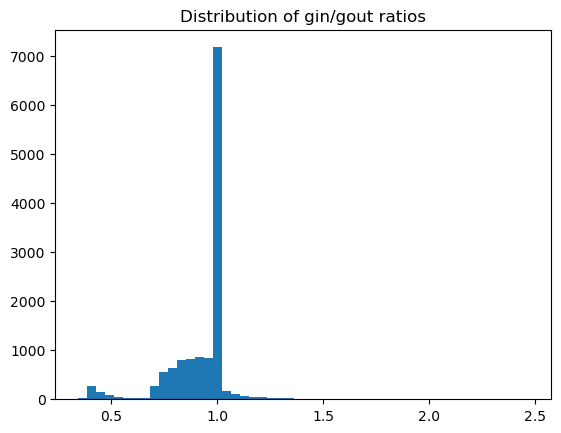

In [11]:
gin_gout_file = "Data/gin_gout_ratio.csv"  
df_features = pd.read_csv(gin_gout_file)


test_info_file = "Data/test_info.csv"  
df_labels = pd.read_csv(test_info_file)

# Extract Capacity (C) and Cross Traffic
C_values = df_labels.iloc[:, 0].values  # First column = Capacity (C)
cross_traffic_values = df_labels.iloc[:, 1].values  # Second column = Cross Traffic

# Compute Available Bandwidth (A = C - Cross Traffic)
A_values = C_values - cross_traffic_values

# Combine A and C as labels
y = np.column_stack((A_values, C_values))  # Shape: (num_samples, 2)

# Convert gin/gout ratio DataFrame to NumPy array
X = df_features.values  # Shape: (num_samples, num_features)

# Check dataset alignment
if len(X) != len(y):
    raise ValueError(f"Mismatch: gin_gout_ratio.csv has {len(X)} rows, test_info.csv has {len(y)} labels.")

# Normalize A and C values using MinMaxScaler
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)  # Scale (A, C) values between 0 and 1

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Plot data distribution to check if gin/gout ratios have useful variations
plt.hist(X.flatten(), bins=50)
plt.title("Distribution of gin/gout ratios")
plt.show()

# Build The Model

In [16]:
# Define the model (same as your `build_bandwidth_estimator`)
def build_bandwidth_estimator(k=25):
    model = keras.Sequential([
        layers.Input(shape=(k,)),  # Input layer (expects 20 features)
        layers.Dense(40, activation='relu'),  # Hidden layer with 40 neurons
        layers.Dense(2, activation='linear')  # Output layer (predicts A and C)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Ensure input dimension matches model expectation
k = X_train.shape[1]
model = build_bandwidth_estimator(k)
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 40)                  │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              82 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 962 (3.76 KB)

 Trainable params: 962 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2623 - mae: 0.4557 - val_loss: 0.1874 - val_mae: 0.3734
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1772 - mae: 0.3649 - val_loss: 0.1658 - val_mae: 0.3648
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1647 - mae: 0.3659 - val_loss: 0.1649 - val_mae: 0.3706
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1639 - mae: 0.3648 - val_loss: 0.1641 - val_mae: 0.3619
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1644 - mae: 0.3634 - val_loss: 0.1619 - val_mae: 0.3608
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1580 - mae: 0.3550 - val_loss: 0.1624 - val_mae: 0.3646
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1613 - mae: 0.3636 - val_loss: 0.1613 - val_mae: 0.3585
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1598 - mae: 0.3580 - val_loss: 0.1599 - val_mae: 0.3607
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1591 - mae:

In [17]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict Available Bandwidth (A) and Capacity (C)
predictions = model.predict(X_test)
print("Predicted A and C values:\n", predictions)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 - mae: 0.3271 
Test Loss: 0.13045799732208252, Test MAE: 0.3166913688182831
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Predicted A and C values:
 [[0.23364168 0.49469203]
 [0.21333808 0.41473514]
 [0.34177303 0.49988496]
 [0.5119712  0.5693545 ]
 [0.44458383 0.5220114 ]
 [0.2772223  0.5027796 ]
 [0.41913274 0.45179656]
 [0.38314906 0.6339643 ]
 [0.21114028 0.4671399 ]
 [0.5105069  0.56499785]
 [0.42103305 0.47716707]
 [0.45469618 0.4895143 ]
 [0.60497713 0.62598103]
 [0.68104815 0.5811515 ]
 [0.5283379  0.48341545]
 [0.5399999  0.54600286]
 [0.2500628  0.4573246 ]
 [0.24875668 0.52827775]
 [0.48348516 0.49982804]
 [0.21833634 0.49451047]
 [0.41871604 0.44496793]
 [0.59939814 0.7007219 ]
 [0.5099904  0.5117085 ]
 [0.23884109 0.43660817]
 [0.23204023 0.4650694 ]
 [0.6723724  0.62565416]
 [0.41375    0.44020343]
 [0.4380773  0.44199052]
 [0.23418081 0.46320692]
 [0.19420338 0.43261996]
 [0.46014673 0.4404893 ]
 [0.29781353 0.45018685]
 [0.262